<a href="https://colab.research.google.com/github/mrchocha/CSE523-Machine-Learning-Fantastic-4/blob/main/CSE523_Machine_Learning_Fantastic_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
!pip install pmdarima
!pip install yfinance

     |████████████████████████████████| 1.5MB 8.4MB/s 
     |████████████████████████████████| 2.1MB 38.2MB/s 
     |████████████████████████████████| 9.5MB 46.7MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 5.5MB 10.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=7342f9dab41a6784f9c25d9040638093ac32e1e64de8c05c68d6d95e33930f3d
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import nltk
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LinearRegression
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import ngrams,everygrams
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sn

nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Tweets Extraction

In [ ]:
from google.colab import drive
# Mounting Drive
drive.mount('/content/drive')

# Changing Directory
% cd /content/drive/MyDrive/ML_Project

# Reading CSV File
data = pd.read_csv('MSFT_sorted.csv', encoding='latin-1')

# Declaring columns
data.columns = ['Unnamed: 0', 'Url', 'time_stamp', 'ids', 'text', 'subjectivity', 'target', 'label']

data.head()

Mounted at /content/drive
/content/drive/MyDrive/ML_Project


,Unnamed: 0,Url,time_stamp,ids,text,subjectivity,target,label
0,0,https://twitter.com/jameyjeff/status/27287474960,2010-10-13 23:37:30+00:00,27287474960,Windows phone 7 app store developers can post ...,0.800000,0.400000,Positive
1,1,https://twitter.com/AlexanderForex/status/2728...,2010-10-13 23:30:56+00:00,27286960834,: Roy Bostock $yhoo's Chair said $msft had 2 p...,0.000000,0.000000,Neutral
2,2,https://twitter.com/Dvolatility/status/2728652...,2010-10-13 23:25:27+00:00,27286528379,: Roy Bostock $yhoo's Chair said $msft had to ...,0.000000,0.000000,Neutral
3,3,https://twitter.com/jhondroulis/status/2728172...,2010-10-13 22:22:31+00:00,27281727866,Bing makes sense. Remember when $MSFT investe...,0.000000,0.000000,Neutral
4,4,https://twitter.com/outsizedreturn/status/2728...,2010-10-13 22:16:58+00:00,27281314383,Florida Hedge Funds Facebook Expands Microsoft...,0.066667,0.033333,Positive


## Tweet Data Cleaning and Preprocessing

### Function Declaration

In [ ]:
#function for cleaning the tweets
def cleantweet(text_data):
  text_data = str(text_data)
  text_data = re.sub(r'@[A-Za-z0-9]+', '',text_data)  #remove mentioned peoples
  text_data = re.sub(r'#','',text_data)             #remove hastags
  text_data = re.sub(r'RT[\s]+','',text_data)       #remove RT
  text_data = re.sub(r'https?:\/\/\S+','',text_data)  #remove urls
  return text_data

#remove Stopwords from the tweet
def remove_stopwords(str):
  str_to_words = nltk.tokenize.word_tokenize(str)
  stoplist=stopwords.words("english")
  str_without_stopwords = ""
  for word in str_to_words:
    if word not in stoplist:
      str_without_stopwords = str_without_stopwords + word + " "
  
  str_ = str_without_stopwords
  return str_

#remove the Punctuation marks and special characters
def remove_punctuation(str):
  list_punc = ['.',',',':',';','?','(',')','[',']','"','\'','-','/','!','$']
  str_without_punc = ""
  for ch in str:
    if ch not in list_punc:
      str_without_punc = str_without_punc + ch 

  str_ = str_without_punc
  return str_

#Spell correction and lemmatization
def spell_correction_lemma_stem(str):
  str_to_words = nltk.tokenize.word_tokenize(str)
  str_spell_correct = ""
  spell = SpellChecker()
  stemmer = PorterStemmer()
  wnl = WordNetLemmatizer()
  #print(wnl.lemmatize("runs"))
  #print(stemmer.stem("rans"))
  for word in str_to_words:
    str_spell_correct = str_spell_correct + wnl.lemmatize(spell.correction(word)) + " "

  str_ = str_spell_correct
  return str_

In [ ]:
#Apply all types of cleaning on whle dataset
data["text"]= data["text"].apply(cleantweet)

data['text'] = data['text'].str.lower()

data['text']= data['text'].apply(remove_stopwords)

data['text']= data['text'].apply(remove_punctuation)

# Dropping garbage values from time_stamp column
arr = []
for i in range(len(data)):
  if(len(data['time_stamp'][i])<25):
    arr.append(i)
data = data.drop(arr)

# converting string to timestamp object
data['time_stamp'] = pd.to_datetime(data['time_stamp'], format='%Y-%m-%d %H:%M:%S%z')

# Forming a new column called Date
data["Date"] = data["time_stamp"].dt.date

# Removing rows having 2011 data
indexes = data[data['Date']>=datetime.datetime.strptime('2011-01-01 11:11:11+00:00', '%Y-%m-%d %H:%M:%S%z').date()].index
data = data.drop(indexes)

# Sorting dataframe according to the Date column
data = data.sort_values(by='Date')

data.head()

,Unnamed: 0,Url,time_stamp,ids,text,subjectivity,target,label,Date
1170,0,https://twitter.com/microsoft_watch/status/152...,2010-06-01 23:47:09+00:00,15211968006,osnews microsoft google security bigger msft,0.500000,0.000000,Neutral,2010-06-01
1284,114,https://twitter.com/microsoft_watch/status/151...,2010-06-01 00:47:36+00:00,15143346257,businessinsider google dumps microsoft window...,0.000000,0.000000,Neutral,2010-06-01
1285,115,https://twitter.com/harmongreg/status/15143270898,2010-06-01 00:46:12+00:00,15143270898,msft consolidating big fall fails support 2...,0.466667,-0.166667,Negative,2010-06-01
1171,1,https://twitter.com/microsoft_watch/status/152...,2010-06-01 23:35:18+00:00,15211297986,newscnet microsoft responds google & 039 win...,0.000000,0.000000,Neutral,2010-06-01
1253,83,https://twitter.com/TheSlush/status/15178212604,2010-06-01 13:37:10+00:00,15178212604,google phasing windows switching mostly mac ...,0.437500,0.187500,Positive,2010-06-01


## Classification

### Class declaration for MNB Classification

In [ ]:
class Multinomial_Naive_Bayes:
  def __init__(self,alpha=1):
    self.alpha=alpha
    self.ngram=1
    self.cat_pos_count=0
    self.cat_neg_count=0
    self.cat_nut_count=0
    self.tot_cat_count=0
    self.cat_pos_prior=0
    self.cat_neg_prior=0
    self.cat_nut_prior=0
    self.word_p=[]

  #Function for tokenizing the text document and generating the ngrams in range
  def Tokenize(self,doc):
    #split the document by space
    doc=doc.split()
    return (everygrams(doc,max_len=min(self.ngram,len(doc))))

  #Function for counting the frequency with respect to label
  def Word_cout(self,document,label):
    count={}
    for doc,cat in zip(document,label):
      for tocken in self.Tokenize(doc):
        if tocken not in count:
          count[tocken]={}
          count[tocken]['Neutral']=0
          count[tocken]['Positive']=0
          count[tocken]['Negative']=0
        count[tocken][cat]+=1
    return count
    
  #Function for finding the proir probability of the label 
  def prior_prob(self, cat_count):
    cat_pos_word_count = cat_neg_word_count = cat_nut_word_count = 0

    for word in cat_count.keys():
       cat_pos_word_count+=cat_count[word]['Positive']
       cat_neg_word_count+=cat_count[word]['Negative']
       cat_nut_word_count+=cat_count[word]['Neutral']
    
    self.cat_neg_count=cat_neg_word_count
    self.cat_pos_count=cat_pos_word_count
    self.cat_nut_count=cat_nut_word_count
    self.tot_cat_count=cat_neg_word_count+cat_pos_word_count+cat_nut_word_count

    cat_pos_prior=cat_pos_word_count/self.tot_cat_count
    cat_neg_prior=cat_neg_word_count/self.tot_cat_count
    cat_nut_prior=cat_nut_word_count/self.tot_cat_count
    return cat_pos_prior,cat_neg_prior,cat_nut_prior

  #Function for finding the probability of the word given the label 
  def word_prob(self,cat_count):
    word_p={}
    for word in cat_count.keys():
        word_p[word]={
            'Positive': (cat_count[word]['Positive']+ self.alpha)/(self.cat_pos_count + 2*self.alpha),
            'Negative': (cat_count[word]['Negative']+ self.alpha)/(self.cat_neg_count + 2*self.alpha),
            'Neutral': (cat_count[word]['Neutral']+ self.alpha)/(self.cat_nut_count + 2*self.alpha),
        }
    print(word_p)
    return word_p    

  #Function for the fitting the data using above functions
  def fit(self,X,Y,ngram=1):
    self.ngram=ngram
    count=self.Word_cout(X,Y)
    self.cat_pos_prior,self.cat_neg_prior,self.cat_nut_prior=self.prior_prob(count)
    self.word_p=self.word_prob(count)
  

  #Predict the label of the given document based on Bayes rule
  def predict(self,X_test):

    cat_pos_word_count = cat_neg_word_count = cat_nut_word_count = 0
    tockens=self.Tokenize(X_test)
    
    for token in tockens:
      if token in self.word_p:
         cat_pos_word_count+=np.log(self.word_p[token]['Positive'])
         cat_neg_word_count+=np.log(self.word_p[token]['Negative'])
         cat_nut_word_count+=np.log(self.word_p[token]['Neutral'])
      else :
        cat_pos_word_count+=np.log(0.5)
        cat_neg_word_count+=np.log(0.5)
        cat_nut_word_count+=np.log(0.5)
    
    prob_pos=self.cat_pos_prior*np.exp(cat_pos_word_count)
    prob_neg=self.cat_neg_prior*np.exp(cat_neg_word_count)
    prob_nut=self.cat_nut_prior*np.exp(cat_nut_word_count)

    if ( prob_nut>prob_neg and prob_nut>prob_pos ):
      return "Neutral"
    elif prob_pos>prob_neg:
      return "Positive"
    elif prob_neg>prob_pos:
      return "Negative"
    else:
      return "Neutral"

### Accuracy for MNB made from scratch

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(data.text,data.label,test_size=0.2)

# Alpha is the smooting factor which prevents the zero probability
classifier = Multinomial_Naive_Bayes(alpha=0.1)
classifier.fit(X_train,Y_train,2)

y_pred=[]
for xt,yt in zip(X_test, Y_test):
  y_pred.append(classifier.predict(xt))

print("Accuracy =", accuracy_score(y_pred,Y_test)*100, '%')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Accuracy = 79.75811584977721 %


### Accuracy for MNB of inbuilt

In [ ]:
# Calling CountVectorizer and converting sentences to feature matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['text'])

X_train,X_test,Y_train,Y_test = train_test_split(X,data.label,test_size=0.2)

MNB = MultinomialNB()
MNB.fit(X_train, Y_train)
pred=MNB.predict(X_test)
acc = accuracy_score(pred,Y_test)
print("Accuracy =", acc*100, "%")

Accuracy = 81.92234245703374 %


## Tweet Feature Extraction Related to stock market

### Grouping data daywise

In [ ]:
#Converting Date column to type of datetime object
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

#Grouping in Dataframe Day wise
grouped_day = data.groupby(pd.Grouper(key='Date',freq='1D'))

dates = data.Date.unique()

day_data_collection = {}

#Creating and storing all the Date wise Dataframe into diffrent dataframes
for d in dates:
  day_data_collection[d] = grouped_day.get_group(d) 

print(day_data_collection[dates[0]])

     Unnamed: 0  ...       Date
1170          0  ... 2010-06-01
1284        114  ... 2010-06-01
1285        115  ... 2010-06-01
1171          1  ... 2010-06-01
1253         83  ... 2010-06-01
...         ...  ...        ...
1208         38  ... 2010-06-01
1209         39  ... 2010-06-01
1210         40  ... 2010-06-01
1211         41  ... 2010-06-01
1207         37  ... 2010-06-01

[116 rows x 9 columns]


### Extracting Feature Daywise

In [ ]:
m_positive_day = {}
m_negative_day = {}
bull_day = {}
agreement_day = {}
message_volume_day = {}

#iterate through dates
for d in dates:
  #finding number of positives
  m_positive_day[d] = day_data_collection[d][day_data_collection[d].label == 'Positive'].shape[0]
  #finding number of negatives
  m_negative_day[d] = day_data_collection[d][day_data_collection[d].label == 'Negative'].shape[0]
  #finding the bullishness
  bull_day[d] = np.log((1 + m_positive_day[d])/(1 + m_negative_day[d]))
  #finding the agreement
  val = 0
  if m_positive_day[d] + m_negative_day[d]==0:
    val=1
  else: val = (1 - (m_positive_day[d] - m_negative_day[d])/(m_positive_day[d] + m_negative_day[d]))
  agreement_day[d] = 1 - ((val)**0.5)
  #finding the message volume
  message_volume_day[d]  = np.log(m_positive_day[d] + m_negative_day[d])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


### Generating all the dates in a year

In [ ]:
generated_dates = pd.date_range(start = "2010-06-01", end = "2010-12-31")
print(generated_dates)

DatetimeIndex(['2010-06-01', '2010-06-02', '2010-06-03', '2010-06-04',
               '2010-06-05', '2010-06-06', '2010-06-07', '2010-06-08',
               '2010-06-09', '2010-06-10',
               ...
               '2010-12-22', '2010-12-23', '2010-12-24', '2010-12-25',
               '2010-12-26', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31'],
              dtype='datetime64[ns]', length=214, freq='D')


### Generalizing twitter features for all the dates (i.e. adding missing values)

In [ ]:
#making dictonary to store the date and features
temp_dict = {"dates":[],"positive":[],"negative":[],"Bullishness":[],"Agreement":[],"Message_volume":[]}

iter = 0

#filling data in dictonary
for d in generated_dates:
  if (d in dates):
    temp_dict["dates"].append(d)
    temp_dict["positive"].append(list(m_positive_day.values())[iter])
    temp_dict["negative"].append(list(m_negative_day.values())[iter])
    temp_dict["Bullishness"].append(list(bull_day.values())[iter])
    temp_dict["Agreement"].append(list(agreement_day.values())[iter])
    temp_dict["Message_volume"].append(list(message_volume_day.values())[iter])
    iter = iter+1 
  else:
    temp_dict["dates"].append(d)
    temp_dict["positive"].append(0)
    temp_dict["negative"].append(0)
    temp_dict["Bullishness"].append(0)
    temp_dict["Agreement"].append(0)
    temp_dict["Message_volume"].append(0) 
  
#convert dictonary to dataframe
date_wise_df = pd.DataFrame.from_dict(temp_dict)
display(date_wise_df)

,dates,positive,negative,Bullishness,Agreement,Message_volume
0,2010-06-01,27,16,0.498991,0.137338,3.761200
1,2010-06-02,26,13,0.656780,0.183503,3.663562
2,2010-06-03,64,14,1.466337,0.400855,4.356709
3,2010-06-04,18,15,0.171850,0.046537,3.496508
4,2010-06-05,3,5,-0.405465,-0.118034,2.079442
...,...,...,...,...,...,...
209,2010-12-27,8,3,0.810930,0.261451,2.397895
210,2010-12-28,11,2,1.386294,0.445300,2.564949
211,2010-12-29,7,1,1.386294,0.500000,2.079442
212,2010-12-30,46,1,3.157000,0.793716,3.850148


##  Financial Data Extraction

In [ ]:
# Gives company's financial information with its ticker symbol as an argument
msft = yf.Ticker("MSFT")

print(msft.info)

start_date = str(generated_dates[0])[:10]
end_date = str(generated_dates[len(generated_dates)-1])[:10]

# Converting dates from string to datetime object
start_date_obj = datetime.datetime.strptime(start_date, '%Y-%m-%d')
end_date_obj = datetime.datetime.strptime(end_date, '%Y-%m-%d')

# Gives history of the company in the date range given
hist = msft.history(start=start_date, end=end_date)

display(hist)
print("Total Days:", (end_date_obj-start_date_obj).days + 1," Trading Days:", len(hist))

{'zip': '98052-6399', 'sector': 'Technology', 'fullTimeEmployees': 163000, 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and deskt

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-01,20.021019,20.632706,20.013176,20.303335,76152400,0.0,0
2010-06-02,20.436652,20.766022,20.177861,20.750338,65718800,0.0,0
2010-06-03,20.820916,21.118919,20.711126,21.064024,67837000,0.0,0
2010-06-04,20.468021,20.836602,20.091598,20.224915,89832200,0.0,0
2010-06-07,20.248439,20.256281,19.793594,19.832806,80456200,0.0,0
...,...,...,...,...,...,...,...
2010-12-23,22.186999,22.464634,22.179066,22.448769,24902500,0.0,0
2010-12-27,22.305992,22.369451,22.115612,22.266329,21652800,0.0,0
2010-12-28,22.186999,22.345648,22.179066,22.218729,23042200,0.0,0


Total Days: 214  Trading Days: 149


### Adding missing values for non-trading days in financial features

In [ ]:
import math

Close = hist['Close']
Highs = hist['High']
Lows = hist['Low']
Open = hist['Open']
Volume = hist['Volume']

sum=0
n=(end_date_obj-start_date_obj).days
trading_days=len(hist)

Return = np.zeros(trading_days, float)
Return[0] = np.log(Close[0]) * 100

# Using Garman and Klass volatility measure
for i in range(0, trading_days):
  sum += (0.5*(math.log(Highs[i]/Lows[i])**2) - (2*math.log(2)-1)*((math.log(Close[i]/Open[i]))**2)) 
  if(i>0): 
    # Calculating return using the formula given in the base paper
    Return[i] = (np.log(Close[i]) - np.log(Close[i-1]))*100


return_dict = {}
close_dict = {}
volatility_dict = {}

financial_features = pd.DataFrame({'Date':[], 'Close':[], 'Return':[], 'Volatility':[]})

j=0
past=''
for d in generated_dates:
  current = str(d)[:10]
  if j<len(hist) and str(hist.index[j])[:10]==current:
    past = str(d)[:10]
    close_dict[current] = Close[j]
    # Using Garman and Klass volatility measure for volatility computation
    volatility_dict[current] = (0.5*(math.log(Highs[j]/Lows[j])**2) - (2*math.log(2)-1)*((math.log(Close[j]/Open[j]))**2))
    return_dict[current] = Return[j]
    j=j+1
  else:
    return_dict[current] = 0
    volatility_dict[current] = 0
    if past=='':
      close_dict[current] = 0
    else:
      close_dict[current] = close_dict[past]

  financial_features = financial_features.append({'Date':d, 'Close':close_dict[current], 'Return':return_dict[current], 'Volatility':volatility_dict[current]}, ignore_index=True)

display(financial_features)
sigma = math.sqrt(sum/n)

# Volatility using Garman and Klass volatility measures
print("Volatility over 30 days of MSFT Stock = ", sigma)

,Date,Close,Return,Volatility
0,2010-06-01,20.303335,301.078517,0.000389
1,2010-06-02,20.750338,2.177735,0.000323
2,2010-06-03,21.064024,1.500404,0.000138
3,2010-06-04,20.224915,-4.065132,0.000608
4,2010-06-05,20.224915,0.000000,0.000000
...,...,...,...,...
209,2010-12-27,22.266329,-0.816014,0.000064
210,2010-12-28,22.218729,-0.214004,0.000027
211,2010-12-29,22.187006,-0.142878,0.000036
212,2010-12-30,22.091818,-0.429949,0.000029


Volatility over 30 days of MSFT Stock =  0.010984598977129384


### Combining features of finance features and twitter features and cleaning dataframe

In [ ]:
# Extracting desired colummns from twitter features and financial features
x = date_wise_df.positive.array
y = financial_features.Close.array
z = date_wise_df.negative.array
a = financial_features.Return.array
b = date_wise_df.Bullishness.array
c = financial_features.Volatility.array 
d = date_wise_df.Message_volume.array
agreement = date_wise_df.Agreement.array
date = financial_features.Date.array

df = pd.DataFrame({'positive':x, 'close':y, 'negative':z, 'Return':a, 'bullishness':b, 'volatility':c, 'agreement':agreement, 'message_volume':d},columns=['positive','close', 'agreement', 'negative', 'Return', 'bullishness', 'volatility', 'message_volume'])

df.index = date

# Assigning 0 to rows where message_volume = 'nan'
index = df.index[np.isinf(df).any(1)]
for i in index:
  df['message_volume'][i]=0

display(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,positive,close,agreement,negative,Return,bullishness,volatility,message_volume
2010-06-01,27,20.303335,0.137338,16,301.078517,0.498991,0.000389,3.761200
2010-06-02,26,20.750338,0.183503,13,2.177735,0.656780,0.000323,3.663562
2010-06-03,64,21.064024,0.400855,14,1.500404,1.466337,0.000138,4.356709
2010-06-04,18,20.224915,0.046537,15,-4.065132,0.171850,0.000608,3.496508
2010-06-05,3,20.224915,-0.118034,5,0.000000,-0.405465,0.000000,2.079442
...,...,...,...,...,...,...,...,...
2010-12-27,8,22.266329,0.261451,3,-0.816014,0.810930,0.000064,2.397895
2010-12-28,11,22.218729,0.445300,2,-0.214004,1.386294,0.000027,2.564949
2010-12-29,7,22.187006,0.500000,1,-0.142878,1.386294,0.000036,2.079442
2010-12-30,46,22.091818,0.793716,1,-0.429949,3.157000,0.000029,3.850148


## Relationship among the features

### Generating Correlation Matrix

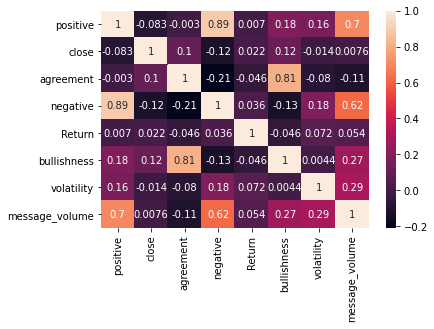

In [ ]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Checking Stationarity of the features using ADF Test

In [ ]:
# Alpha is the threshold value which decides whether to reject or keep null hypothesis
alpha = 0.05
result = adfuller(df.Return)
p_val = result[1]

if p_val<=alpha:
  print("Return data series is stationary.")
else:
  print("Return data series is non-stationary.")

result = adfuller(df.close)
p_val = result[1]

if p_val<=alpha:
  print("Close data series is stationary.")
else:
  print("Close data series is non-stationary.")

result = adfuller(df.positive)
p_val = result[1]

if p_val<=alpha:
  print("Positive data series is stationary.")
else:
  print("Positive data series is non-stationary.")

result = adfuller(df.negative)
p_val = result[1]

if p_val<=alpha:
  print("Negative data series is stationary.")
else:
  print("Negative data series is non-stationary.")

result = adfuller(df.bullishness)
p_val = result[1]

if p_val<=alpha:
  print("Bullishness data series is stationary.")
else:
  print("Bullishness data series is non-stationary.")

result = adfuller(df.volatility)
p_val = result[1]

if p_val<=alpha:
  print("Volatility data series is stationary.")
else:
  print("Volatility data series is non-stationary.")

result = adfuller(df.message_volume)
p_val = result[1]

if p_val<=alpha:
  print("Message_volume data series is stationary.")
else:
  print("Message_volume data series is non-stationary.")

result = adfuller(df.agreement)
p_val = result[1]

if p_val<=alpha:
  print("Agreement data series is stationary.")
else:
  print("Agreement data series is non-stationary.")

Return data series is stationary.
Close data series is non-stationary.
Positive data series is stationary.
Negative data series is stationary.
Bullishness data series is stationary.
Volatility data series is stationary.
Message_volume data series is non-stationary.
Agreement data series is stationary.


### Finding maximum lag using F-test

In [ ]:
lag = 5

# Calling granger Causality Test for all of the lag
test_result = grangercausalitytests(df[['positive', 'close']], lag)

# Assigning p values of GCA of chi test
p_vals = [test_result[i+1][0]['ssr_chi2test'][1] for i in range(lag)]

# Storing lag value and corresponding f value in an array
f_lag_vals = [(test_result[i+1][0]['ssr_ftest'][0], test_result[i+1][0]['ssr_ftest'][3]) for i in range(lag)]

display("Min p-values: ", np.min(p_vals))

print("F-test values: ", f_lag_vals)

mx = -math.inf
mx_lag = -1

# Finding the lag which has maximum f value
for i in range(lag):
  if f_lag_vals[i][0] > mx:
    mx = f_lag_vals[i][0]
    mx_lag = f_lag_vals[i][1]

print("Lag with max F-test value: ", mx_lag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2000  , p=0.2746  , df_denom=210, df_num=1
ssr based chi2 test:   chi2=1.2171  , p=0.2699  , df=1
likelihood ratio test: chi2=1.2136  , p=0.2706  , df=1
parameter F test:         F=1.2000  , p=0.2746  , df_denom=210, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4709  , p=0.2321  , df_denom=207, df_num=2
ssr based chi2 test:   chi2=3.0129  , p=0.2217  , df=2
likelihood ratio test: chi2=2.9917  , p=0.2241  , df=2
parameter F test:         F=1.4709  , p=0.2321  , df_denom=207, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2783  , p=0.2829  , df_denom=204, df_num=3
ssr based chi2 test:   chi2=3.9664  , p=0.2651  , df=3
likelihood ratio test: chi2=3.9296  , p=0.2692  , df=3
parameter F test:         F=1.2783  , p=0.2829  , df_denom=204, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0109  , p=0.4028  

'Min p-values: '

0.2216906286570747

F-test values:  [(1.1999525681722722, 1), (1.4709424234046762, 2), (1.2782857662019411, 3), (1.0109488157870516, 4), (1.0812632706102923, 5)]
Lag with max F-test value:  2


### Converting Non-Stationary series to Stationary series

In [ ]:
close = df.close.array
message_volume = df.message_volume.array
original = len(close)

# Using diff function, it converts non-stationary to stationary series with the lag given
close = np.diff(close, n=mx_lag)
message_volume = np.diff(message_volume, n=mx_lag)

for i in range(original-len(close)):
  close = np.concatenate((close, [0]))

result = adfuller(close)
p_val = result[1]

if p_val<=alpha:
  print("Close data series is stationary.")
else:
  print("Close data series is non-stationary.")

result = adfuller(message_volume)
p_val = result[1]

if p_val<=alpha:
  print("Message_volume data series is stationary.")
else:
  print("Message_volume data series is non-stationary.")

Close data series is stationary.
Message_volume data series is stationary.


### Granger's Causality Analysis (GCA)

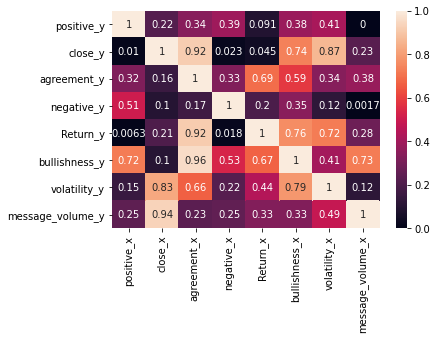

In [ ]:
maxlag=mx_lag

test = 'ssr-chi2test'
# Function which generates GCA matrix and its arguments are dataframe, its features,
# the test and verbose (whether to print anything or not)
def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    # Initializing data frame with zeros 
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    # Iterating through each of the columns and rows and assigning gca test result's min p value of all the lags
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

dataset = grangers_causality_matrix(df, variables=df.columns)

# produces heatmap of a matrix
sn.heatmap(dataset, annot=True)
plt.show()

### Inference From Above GCA Matrix:
- Positive tweets, Negative tweets, Return causes Close prices.
- Message_volume causes Positive tweets and Negative tweets.
- Positive tweets, negative tweets causes Return.

### Dropping Less Important Columns

In [ ]:
df = df.drop(columns=['agreement', 'bullishness', 'volatility', 'message_volume'])

display(df.head())

,positive,close,negative,Return
2010-06-01,27,20.303335,16,301.078517
2010-06-02,26,20.750338,13,2.177735
2010-06-03,64,21.064024,14,1.500404
2010-06-04,18,20.224915,15,-4.065132
2010-06-05,3,20.224915,5,0.000000


## Prediction and Forecasting

### Separating Trend, seasonality from series

- Trend: The increasing or decreasing value in the series. 
- Seasonality: The repeating short-term cycle in the series.
- It also provides access to the residuals, which are the time series after the trend, and seasonal components are removed.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

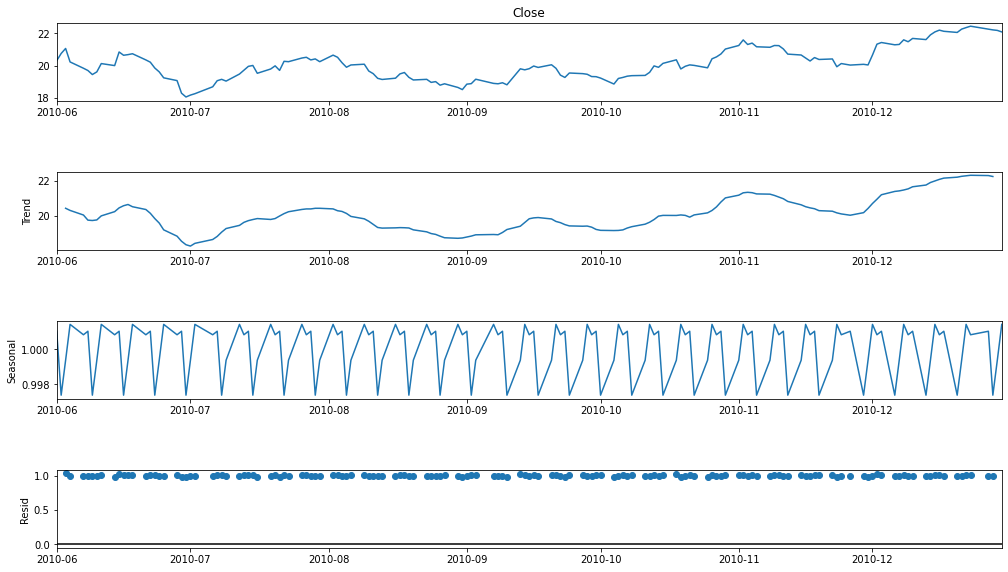

In [ ]:
df_close = hist['Close']
window_size=5
result = seasonal_decompose(df_close, model='multiplicative', freq = window_size)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

### Splitting data into Train and Test and visualizing

Train:Test = 80:20

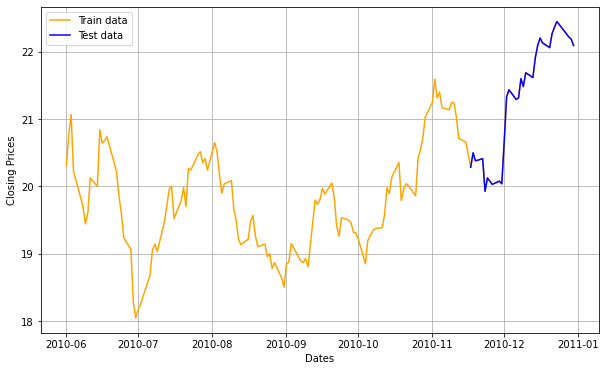

In [ ]:
df_log = (hist['Close'])
train_data, test_data = df_log[:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'orange', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### ARIMA Model

#### Defining optimal p, d, q vals using auto_arima

- A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where: p is the number of autoregressive terms, d is the number of nonseasonal differences needed for stationarity, and q is the number of lagged forecast errors in the prediction equation.

> p = #AR-Terms = Autoregressive Terms
- An AR(1) autoregressive process is one in which the current value is based on the immediately preceding value, while an AR(2) process is one in which the current value is based on the previous two values. An AR(0) process is used for white noise and has no dependence between the terms.

* Q = Lagged forecast error terms = Moving Average Terms

##### What is AIC?
- The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. ... AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

##### Use of AIC?
- Akaike's Information Criterion (AIC), which was useful in selecting predictors for regression, is also useful for determining the order of an ARIMA model.

<img src="https://otexts.com/fpp2/arimaflowchart.png" alt="Drawing" height="800" width="600"/>

*Figure 1: General process for forecasting using an ARIMA model.*


In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',           # use adftest to find optimal 'd'
max_p=window_size, max_q=window_size, # maximum p and q
m=1,                 # frequency of series
d=0,                 # let model determine 'd'
seasonal=False,      # No Seasonality
# start_P=0,           # Seasonal model parameter
# D=0,              # Seasonal model parameter 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
max_order = window_size,
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1050.478, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=54.999, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=52.411, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=54.136, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=55.733, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=57.946, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=42.741, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.196, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=44.989, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=45.418, Time=0.45 sec
 ARIMA(2,0

#### Defining ARIMA Model

In [ ]:
model = ARIMA(train_data, order=(2, 0, 1)) # Most optimal p, d, q values
fitted = model.fit(disp=1)

print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  119
Model:                     ARMA(2, 1)   Log Likelihood                 -16.852
Method:                       css-mle   S.D. of innovations              0.276
Date:                Sun, 11 Apr 2021   AIC                             43.704
Time:                        09:20:34   BIC                             57.599
Sample:                             0   HQIC                            49.346
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          19.7664      0.268     73.826      0.000      19.242      20.291
ar.L1.Close     1.8597      0.314      5.920      0.000       1.244       2.475
ar.L2.Close    -0.8803      0.278     -3.172    

#### Forecasting

In [ ]:
# Forecast
# 95% confidence
# alpha = 1 - (confidence%)/100
fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)  

#### Visualizing Forecast Values

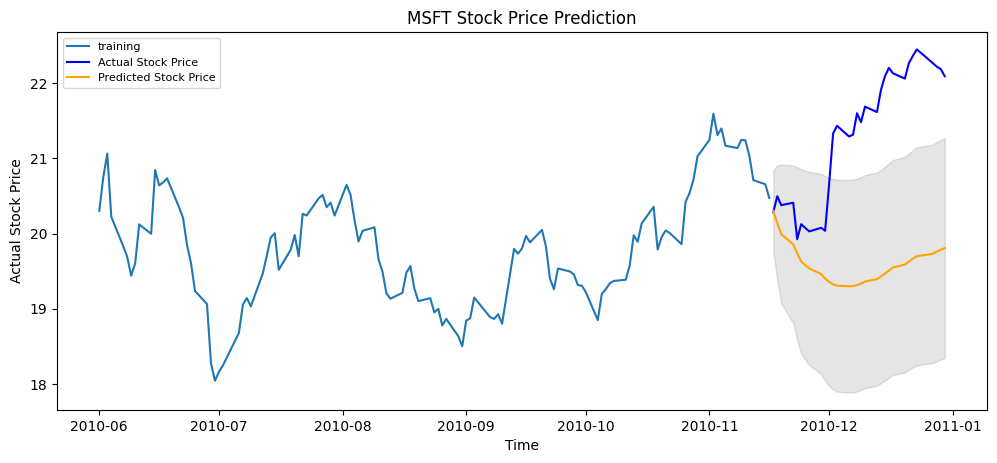

In [ ]:
# Converts forecast array to series with index of dates
fc_series = pd.Series(fc, index=test_data.index)

# LCL = Lower confidence limit is minimum value of the forecast
lower_series = pd.Series(conf[:, 0], index=test_data.index)

# UCL = Upper Confidence Limit is maximum value of the forcast
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### RMSE Computation for ARIMA Model

In [ ]:
print("[RMSE] Root Mean Squared Error =", math.sqrt(mean_squared_error(test_data, fc)))

# print(math.sqrt(np.sum(se)/(len(test_data)*len(test_data))))

[RMSE] Root Mean Squared Error = 1.987916046232329


### Linear Regression 
- Here, we are performing linear regression on data with columns = ['positive tweets', 'negative tweets', 'Close price', 'Return'].
- And the predicting column is 'Close price'.
- The method for performing LinearRegression is using Ordinary Least Squares.

#### Data Defining for Linear Regression

In [ ]:
df['close_yesterday']=df.close.shift(1).array
df['close_yesterday'][0]=df['close'][0]

x=df[['positive','close_yesterday','negative']]
y=df['close']

# Splitting training and test into 70:30 ratio
X_train = x[:int(0.7*len(x))]
y_train = y[:int(0.7*len(y))]
X_test = x[int(0.7*len(x)):]
y_test = y[int(0.7*len(y)):]

display(df.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,positive,close,negative,Return,close_yesterday
2010-06-01,27,20.303335,16,301.078517,20.303335
2010-06-02,26,20.750338,13,2.177735,20.303335
2010-06-03,64,21.064024,14,1.500404,20.750338
2010-06-04,18,20.224915,15,-4.065132,21.064024
2010-06-05,3,20.224915,5,0.000000,20.224915


#### Visualizing Regression Prediction

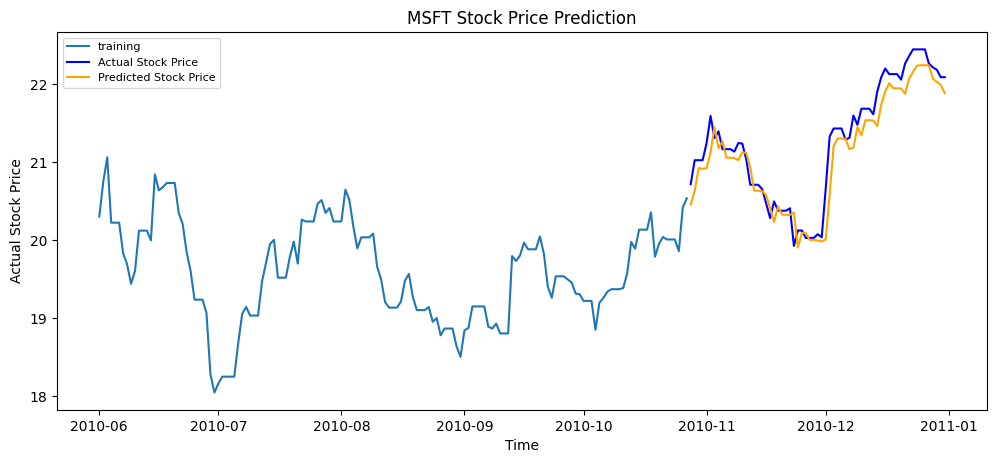

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
y_pred=reg.predict(X_test)

# Converting normal prediction array into a series where index is date.
y_pred_series = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, color = 'blue', label='Actual Stock Price')
plt.plot(y_pred_series, color = 'orange',label='Predicted Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### RMSE Computation for Linear Regression

In [ ]:
mse = math.sqrt(mean_squared_error(y_test,y_pred))
print("[RMSE] Root Mean Squared Error =", mse)

[RMSE] Root Mean Squared Error = 0.23642967897987452
